In [1]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

# <a id='data'>1. Fetch the data</a>

In [2]:
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
prices.name = 'prices'

Since, the validation data is now available for the days 1914-1941, Adding zero sales for days: d_1942 - d_1969(Test)

In [3]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [4]:
# sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
# calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
# prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [5]:

#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)


In [6]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [7]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [8]:
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)

In [9]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 23 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
 22  revenue       float32       
dtypes: category(11), datetime64[ns

In [11]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [12]:
#1
#del group, group_price_cat, group_price_store, group_state, group_state_store, cal_data
#gc.collect();

#2
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
#3
df.drop('date',axis=1,inplace=True)

<a id = 'F2'><h2>5.2 Introduce Lags</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

Introduce lags to the the target variable `sold`. The maximum lag I have introduced is 36 days. It's purely upto you how many lags you want to introduce.

In [13]:
#Introduce lags
lags = [24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

<a id = 'F3'><h2>5.3 Mean Encoding</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value. I have calculated mean encodings on the basis of following logical features I could think of:-
- item
- state
- store
- category
- department
- category & department
- store & item
- category & item
- department & item
- state & store
- state, store and category
- store, category and department

<h2>Feel free to add more!</h2>

In [14]:
# df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
# df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
# df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
# df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
# df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
# df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
# df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
# df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
# df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
# df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
# df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
# df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

<a id = 'F4'><h2>5.4 Rolling Window Statistics</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

Here’s an awesome gif that explains this idea in a wonderfully intuitive way:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/3hotmk.gif)
`This method is called the rolling window method because the window would be different for every data point.`

I'll be calculating weekly rolling avearge of the items sold. More features like rolling min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [15]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

<a id = 'F5'><h2>5.5 Expanding Window Statistics</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

This is simply an advanced version of the rolling window technique. In the case of a rolling window, the size of the window is constant while the window slides as we move forward in time. Hence, we consider only the most recent values and ignore the past values. Here’s a gif that explains how our expanding window function works:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/12/output_B4KHcT.gif)

I'll be calculating expanding avearge of the items sold. More features like expanding min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [16]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

<a id = 'F6'><h2>5.6 Trends</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

I will be creating a selling trend feature, which will be some positive value if the daily items sold are greater than the entire duration average **( d_1 - d_1969 )** else negative. More trend features can be added but I'll only add this one to keep it simple.

In [17]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

<a id = 'F6'><h2>5.7 Save the data</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

Now since all the new features are created, let's save the data so that it can be trained separately.Also, lags introduce a lot of Null values, so I'll remove data for first 35 days as I have introduced lags till 36 days.

In [18]:
df = df[df['d']>=36]

Let's look at our new dataframe.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 27 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int16  
 1   item_id              int16  
 2   dept_id              int8   
 3   cat_id               int8   
 4   store_id             int8   
 5   state_id             int8   
 6   d                    int16  
 7   sold                 int16  
 8   wm_yr_wk             int16  
 9   weekday              int8   
 10  wday                 int8   
 11  month                int8   
 12  year                 int16  
 13  event_name_1         int8   
 14  event_type_1         int8   
 15  event_name_2         int8   
 16  event_type_2         int8   
 17  snap_CA              int8   
 18  snap_TX              int8   
 19  snap_WI              int8   
 20  sell_price           float16
 21  revenue              float32
 22  sold_lag_24          float16
 23  sold_lag_36          flo

Save the data for training.

In [20]:
# df.to_pickle('data.pkl')
# del df
# gc.collect();

# <a id='pred'>6. Modelling and Prediction</a>

In [21]:
#data = pd.read_pickle('./data.pkl')
#data = df
valid = df[(df['d']>=1914) & (df['d']<1942)][['id','d','sold']]
test = df[df['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [22]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df_temp = df[df['store_id']==store]
    
    #Split the data
    X_train, y_train = df_temp[df_temp['d']<1914].drop('sold',axis=1), df_temp[df_temp['d']<1914]['sold']
    X_valid, y_valid = df_temp[(df_temp['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df_temp[(df_temp['d']>=1914) & (df_temp['d']<1942)]['sold']
    X_test = df_temp[df_temp['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.693643	training's l2: 0.481141	valid_1's rmse: 0.429568	valid_1's l2: 0.184528
[40]	training's rmse: 0.634912	training's l2: 0.403113	valid_1's rmse: 0.384198	valid_1's l2: 0.147608
[60]	training's rmse: 0.607025	training's l2: 0.36848	valid_1's rmse: 0.372615	valid_1's l2: 0.138842
[80]	training's rmse: 0.585833	training's l2: 0.3432	valid_1's rmse: 0.362925	valid_1's l2: 0.131715
[100]	training's rmse: 0.573268	training's l2: 0.328636	valid_1's rmse: 0.360621	valid_1's l2: 0.130048
[120]	training's rmse: 0.560524	training's l2: 0.314187	valid_1's rmse: 0.351369	valid_1's l2: 0.12346
[140]	training's rmse: 0.550117	training's l2: 0.302628	valid_1's rmse: 0.346626	valid_1's l2: 0.12015
[160]	training's rmse: 0.541347	training's l2: 0.293057	valid_1's rmse: 0.344388	valid_1's l2: 0.118603
[180]	training's rmse: 0.530935	training's l2: 0.281892	valid_1's rmse: 0.34263

**Plotting feature importances**

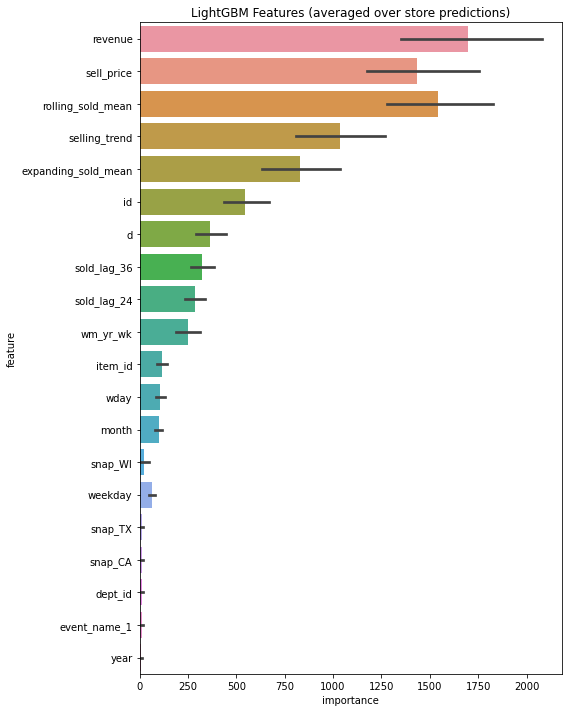

In [23]:
feature_importance_df = pd.DataFrame()
features = [f for f in df.columns if f != 'sold']
for filename in os.listdir('/kaggle/working/'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

**Make the submission**

If you remember for EDA, feature engineering and training I had melted the provided data from wide format to long format. Now, I have the predictions in long format but the format to be evaluated for the competition is in long format. Therefore, I'll convert it into wide format using `pivot` function in pandas. Below is an image explaining the pivot function.
<img src='https://pandas.pydata.org/pandas-docs/version/0.25.3/_images/reshaping_pivot.png' style="width:500px;height:300px;">

In [24]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = False
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
    validation['id']=pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv').id
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission.csv',index=False)